# PHYS-GA2059 - Statistics and Data Science for Physicists
# Student: Gehan Ranepura
## Problem Set #4

In [1]:
import sys
import corner
import pandas as pd
import numpy as np
import ipywidgets as widgets
import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pkl
import pylab as pyplt
import random
import scipy as sci

from numpy.linalg import inv
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from numpy import random
from matplotlib import patches
from pylab import cm
from scipy import linalg
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import norm, invgamma, multivariate_normal

## Problem 1: 
Go back to the 11th data set (the last data set) from Problem 2 of Problem Set 2 and sample in the 6-dimensional space (5 linear amplitudes and the period T) with some sensible priors on all 6 parameters (we’ll discuss possible priors in class). 

Make a “corner plot” of the posterior sampling, and plot a sampling of 16 independent samples from the posterior in the space of the data, on the data.

## Solution to Problem 1

Recall from Problem 2 from Problem Set 2, the model we used to define our data set was,

$$ 
\begin{align}
\mu_i &= A_3 \cos(\frac{2\pi}{T'} t) + A_4 \sin(\frac{2\pi}{T'} t) + A_1 \cos(\frac{2\pi}{T} t) + A_2 \sin(\frac{2\pi}{T} t) + \epsilon_i + B \\
\end{align}
$$

where, 
- One signal has given period $T=100days$ and amplitudes $A_1$ and $A_2$ 
- A second signal has unknown period $T'$ and amplitudes $A_3$ and $A_4$
- A total DC shift $B$. 
- $\{(t_i,y_i)\}$ is the given data set, and $\epsilon_i \sim \mathcal{N}(0,\sigma_i^2)$ is the Gaussian noise for each data point with a mean of 0 and given variance $\sigma_i^2$.

Sample the 6-dimensional space, where the 5 linear amplitides ($A_1, A_2, A_3, A_4, B$) and the period $T'$, given $T=100$

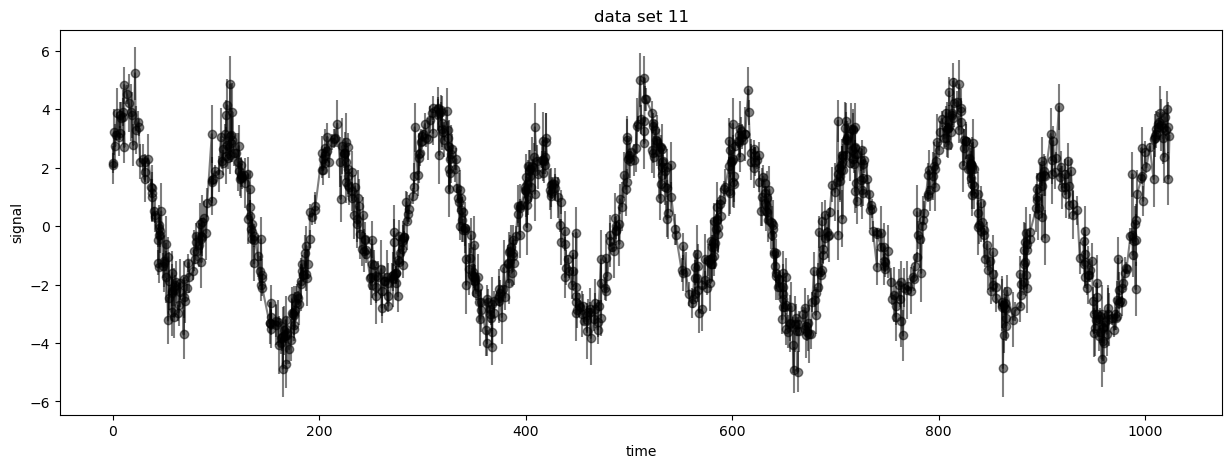

In [2]:
with open("data.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`

# - data[0] is the array of times (day units, say?)
# - data[1] is the array of uncertainties (m/s units, say?)
# - data[2:13] are data sets (m/s units, say?).
# There are 11 data sets in all; they are illustrated in this code block.
for i in range(12, 13):
    pyplt.figure(figsize=(15, 5))
    pyplt.errorbar(data[0], data[i], yerr=data[1], color="k", marker="o", alpha=0.5)
    pyplt.xlabel("time")
    pyplt.ylabel("signal")
    pyplt.title("data set {}".format(i-1))

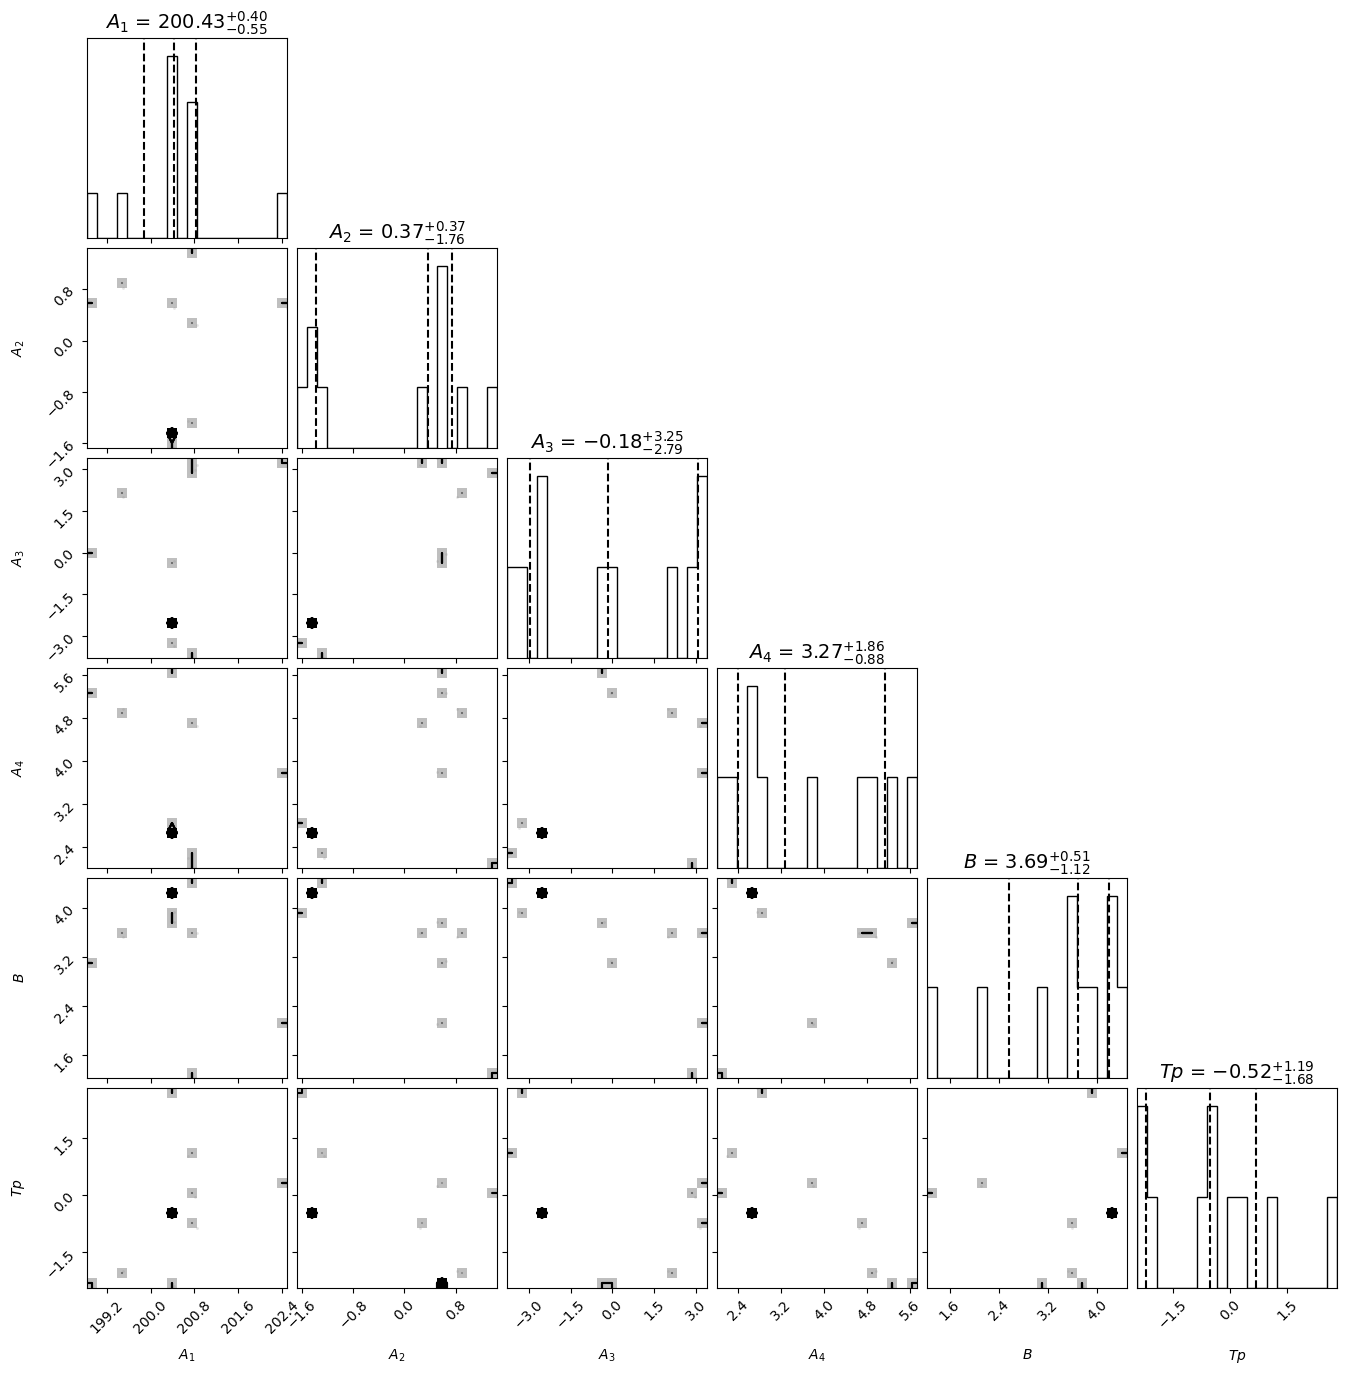

In [288]:
# Create the definition for our log-likelihood function
def loglike_M2(pars, data, info):
    Tp,A1,A2,A3,A4,B = pars        # 5 linear amplitides and T'
    t, y = data                    # X-axis and Y-axis
    sig = info                     # Error in y-axis
    
    # Create function for mu, using 1st signal with period of T = 100days and 2nd signal with unknown period T'
    T = 100
    mu = A3 * np.cos(2* np.pi/Tp * t) + A4 * np.sin(2* np.pi/Tp * t)+ A1 * np.cos(2* np.pi/T * t) + A2 * np.sin(2* np.pi/T * t) + B 

    # Calculate likelood function for given pars, data and info
    return -0.5 * np.sum( ((y - mu)/sig )**2 )

# Create the definition for setting our priors for the amplitudes and period
# Set amplitudes and period as normal distributions
# Set the variance to be relatively large
def log_prior(pars): 
    Tp = norm(0,500)
    A1, A2, A3, A4 = norm(0,10), norm(0,10), norm(0,10), norm(0,10) 
    B = norm(0,5)
    return np.log( Tp.pdf(pars[0]) * A1.pdf(pars[1]) * A2.pdf(pars[2]) * A3.pdf(pars[3]) * A4.pdf(pars[4]) * B.pdf(pars[5]) )
     
xdata = data[0]
ydata_err = data[1]
ydata = data[i]

pars_list = []
N = 10
pars = np.array([200,1,1,1,1,1])

i = 0
while i < N:
    pars_prime = multivariate_normal( pars, 2*np.identity(6) ).rvs()
    r = np.random.uniform() 
    Q_prime = log_prior(pars_prime) + loglike_M2(pars_prime, (xdata, ydata), ydata_err)
    Q       = log_prior(pars)       + loglike_M2(pars_prime, (xdata, ydata), ydata_err)
    xi      = np.exp(Q_prime - Q)
    #xi = np.min( (np.exp(Q_prime - Q),1) )
    if xi > r:
        pars = pars_prime
    pars_list.append(pars)
    i += 1

samples = np.vstack(pars_list)
nsamples, ndim = samples.shape
figure  = corner.corner(samples,
    labels=[
        r"$A_1$",
        r"$A_2$",
        r"$A_3$",
        r"$A_4$",
        r"$B$",
        r"$Tp$"],
    quantiles=[0.16, 0.5, 0.84],                  
    show_titles  = True, 
    title_kwargs = {"fontsize": 14}
)
params = np.mean(samples, axis = 0)

## Problem 2: 
Go back to the 11th data set (the last data set) from Problem 2 of Problem Set 2, and plot the residuals (data minus best-fit model expectation) away from the one-period (100-day-period) model, but folded at the period of the putative best-fit second period T. 

Is it believable? That is, check the model, visually. “Folded” here means instead of plotting against time t you plot against (t % T), because in python % is the mod operator.

## Solution to Problem 2

Recall from Problem 2 from Problem Set 2, the models we used to define our data set were,

Model 2 : dataset 11 --> A1 = 1.9683412894982613,  A2 = 2.2933835618066203, A3 = 0.10726737095081902, A4 = 0.7825842589686837, B = 0.032093610908818446, Tp_max = 268.9795918367347 


Text(0, 0.5, ' Residue Signal ')

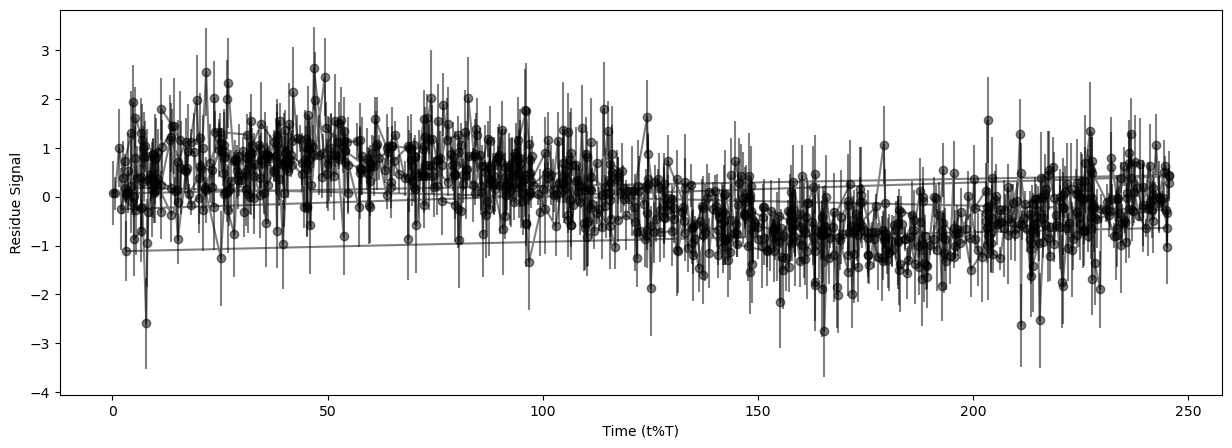

In [280]:
df = pd.read_pickle("data.pkl")     
X_data = df[:,0]
Y_data_err = df[:,1]
Y_data = df[:,12]

xdata = data[0]
ydata_err = data[1]
ydata = data[12]

# Create the definition for our log-likelihood function and what it returns
def loglike_M2(pars, data, info):
    Tp,A1,A2,A3,A4,B = pars
    t, y = data
    sig = info
    T = 100
    
    # Create function for mu, using 1st signal with period of T = 100days and 2nd signal with unknown period T'
    mu = A3 * np.cos(2* np.pi/Tp * t) + A4 * np.sin(2* np.pi/Tp * t) + \
         A1 * np.cos(2* np.pi/T * t)  + A2 * np.sin(2* np.pi/T * t)  + B 
    return -0.5 * np.sum( ((y - mu)/sig )**2 )

Tps = np.linspace(1,1500,50)
profloglike_s = []
profpars_s = []
for Tp in Tps:
    fun    = lambda a: -loglike_M2( np.concatenate(([Tp],a)), (xdata, ydata), ydata_err)  
    res_Tp = minimize(fun, [1,1,1,1,1] )
    profloglike_s.append(-res_Tp.fun)
    profpars_s.append(res_Tp.x)

profloglike_s = np.array(profloglike_s)
profpars_s    = np.array(profpars_s)   

Tp_max                           = Tps[np.argmax(profloglike_s)]
A1_M2, A2_M2, A3_M2, A4_M2, B_M2 = profpars_s[np.argmax(profloglike_s)]
print("Model 2 : dataset {} --> A1 = {},  A2 = {}, A3 = {}, A4 = {}, B = {}, Tp_max = {} "\
                   .format(i-1, A1_M2, A2_M2, A3_M2, A4_M2, B_M2, Tp_M2) )


M1 = A1_M2 * np.cos(2* np.pi/T * data[0]) + A2_M2 * np.sin(2* np.pi/T * data[0]) + B_M2

# % is the remainder of the division
pyplt.figure(figsize=(15, 5))
plt.errorbar(xdata%Tp_max, ydata - M1, ydata_err, color="k", marker="o", alpha=0.5)
plt.xlabel(' Time (t%T) ')
plt.ylabel(' Residue Signal ')

## Problem 3: 
Re-do problem 2 of Problem Set 2 using K-fold cross-validation with K=8. 

That is, fit the 1- and 2-period models to all but one eighth of each data set and predict the held-out eighth, and repeat for all eight held-out eighths, for all 11 data sets. Which is a better model in each case? 

Now compute the AIC and BIC instead. Which is a better model according to these? Make a table, maybe?

## Solution to Problem 3

Recall from Problem 2 from Problem Set 2, the models we used to define our data set were,

For the probabilistic model $M_1$, assuming the data contains one sinosoidal signal:

$$
\begin{align}
\mu_i &= A_1 \cos(\frac{2\pi}{T } t) + A_2 \sin(\frac{2\pi}{T } t) + \epsilon_i + B \\
\end{align}
$$

For the probabilistic model $M_2$, assuming the data contains two sinosoidal signal:

$$ 
\begin{align}
\mu_i &= A_3 \cos(\frac{2\pi}{T'} t) + A_4 \sin(\frac{2\pi}{T'} t) + A_1 \cos(\frac{2\pi}{T} t) + A_2 \sin(\frac{2\pi}{T} t) + \epsilon_i + B \\
\end{align}
$$

For both models, perform parameter optimization with 1/8 of the datapoints removed for each datset.

Then, use model achieved to plot all the datapoints for each dataset

Model 1 : dataset 1 --> A1 = -0.07963978243736436,  A2 = 0.027384018681217596, B = 0.19506067378563952 
Model 2 : dataset 1 --> A1 = -0.12150838510246688,  A2 = 0.04847143718609459, A3 = -0.09471791975918585, A4 = -0.044971189029376836, B = 0.24738591856167688, Tp_max = 209.4285714285715 
AIC : dataset 1 --> Model 1 = -15.100511649486243,  Model 2 = -42.34776257328448 
BIC : dataset 1 --> Model 1 = -8.62386239940723,  Model 2 = -29.39446407312645 
Model 1 : dataset 2 --> A1 = -0.23250207869872927,  A2 = -0.42703229158630224, B = 0.4226024284863642 
Model 2 : dataset 2 --> A1 = 0.02908183076990078,  A2 = 0.054973878841369284, A3 = 0.19925126835744886, A4 = -0.28197576092886584, B = 0.5167391578671224, Tp_max = 30.77551020408163 
AIC : dataset 2 --> Model 1 = -15.855757858866824,  Model 2 = -33.53325330312282 
BIC : dataset 2 --> Model 1 = -9.37910860878781,  Model 2 = -20.579954802964792 
Model 1 : dataset 3 --> A1 = -0.143958236281877,  A2 = 0.12629665186391614, B = 0.38163335831721573

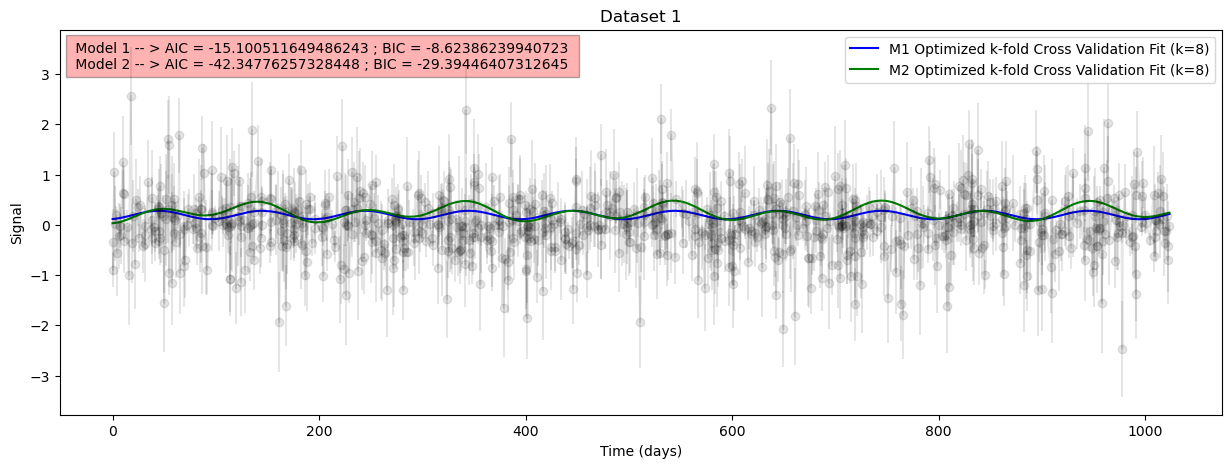

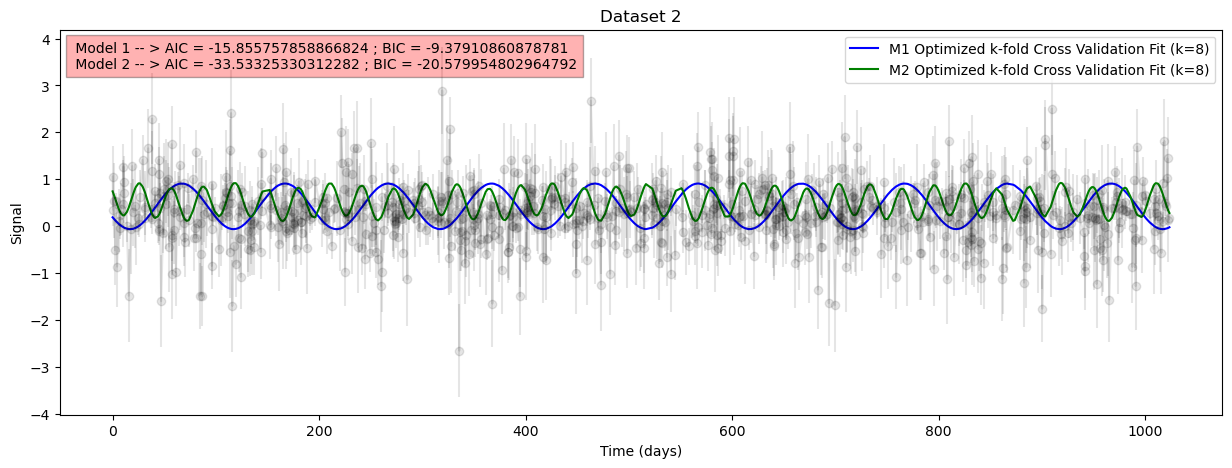

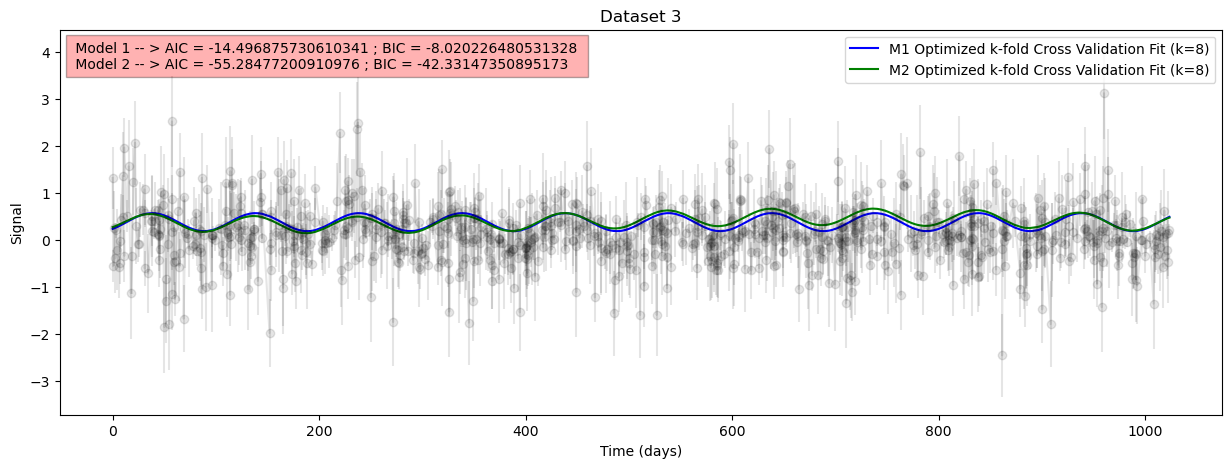

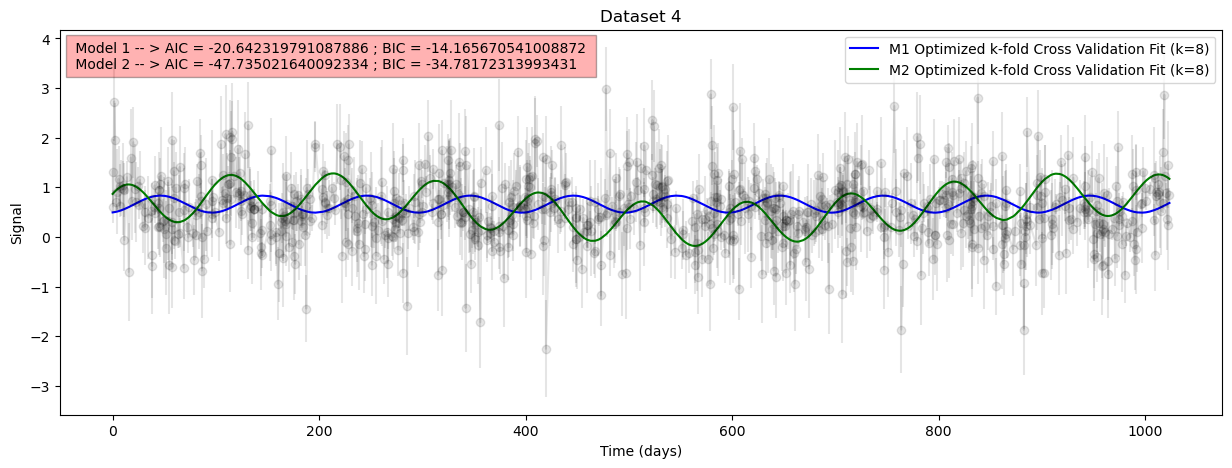

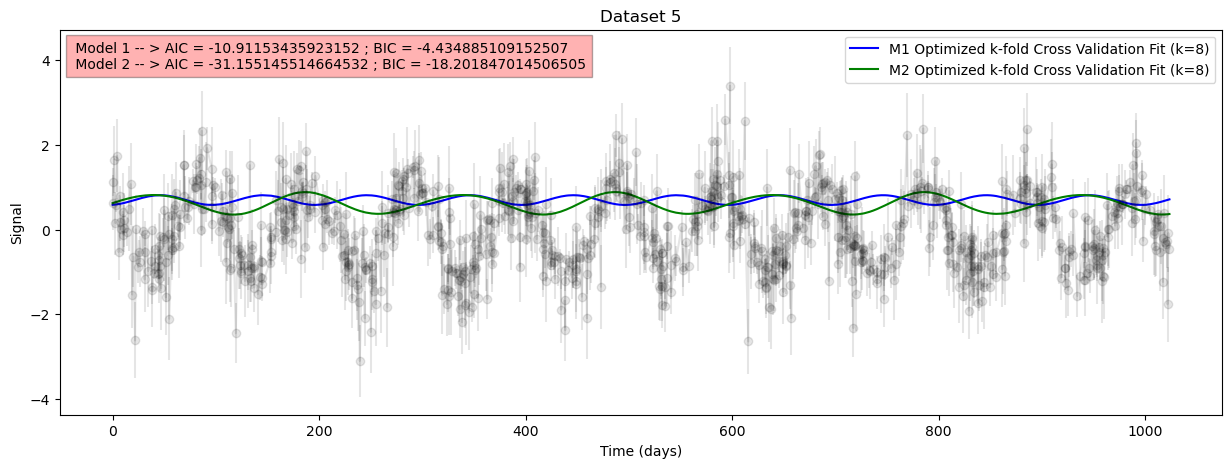

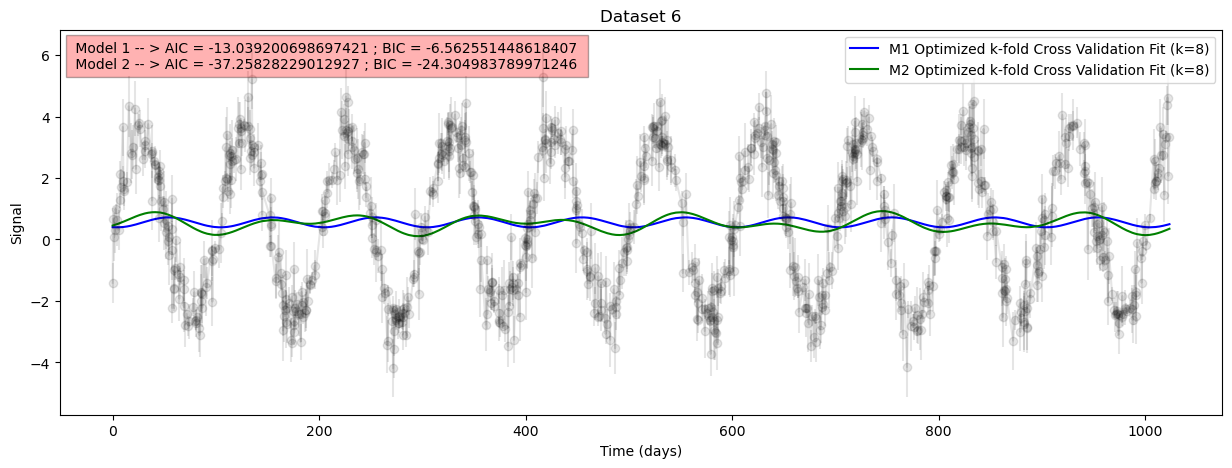

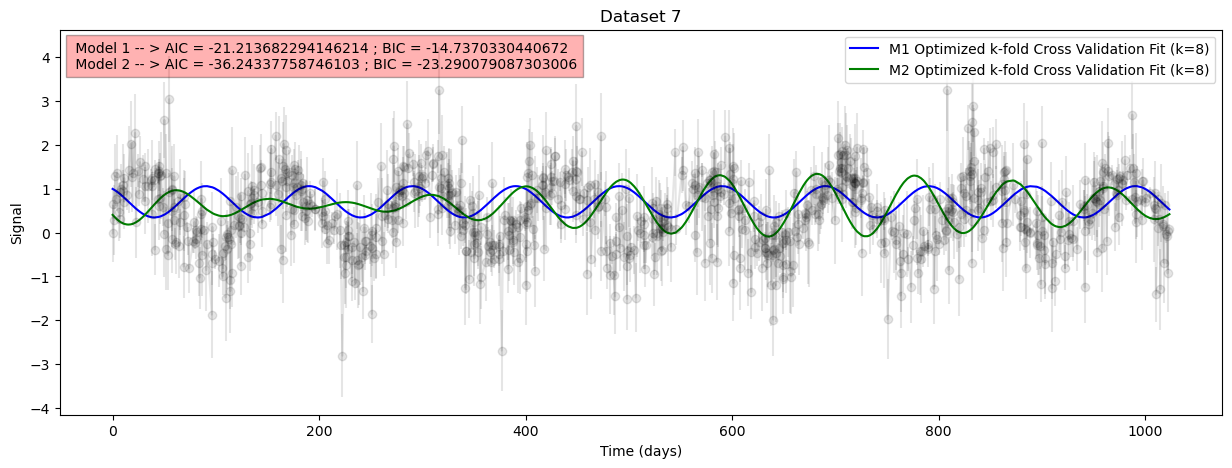

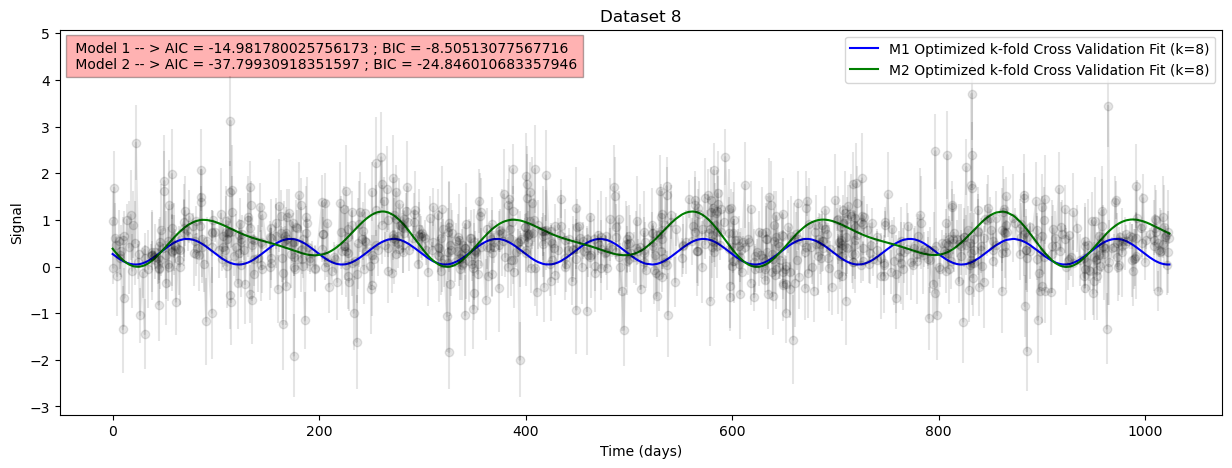

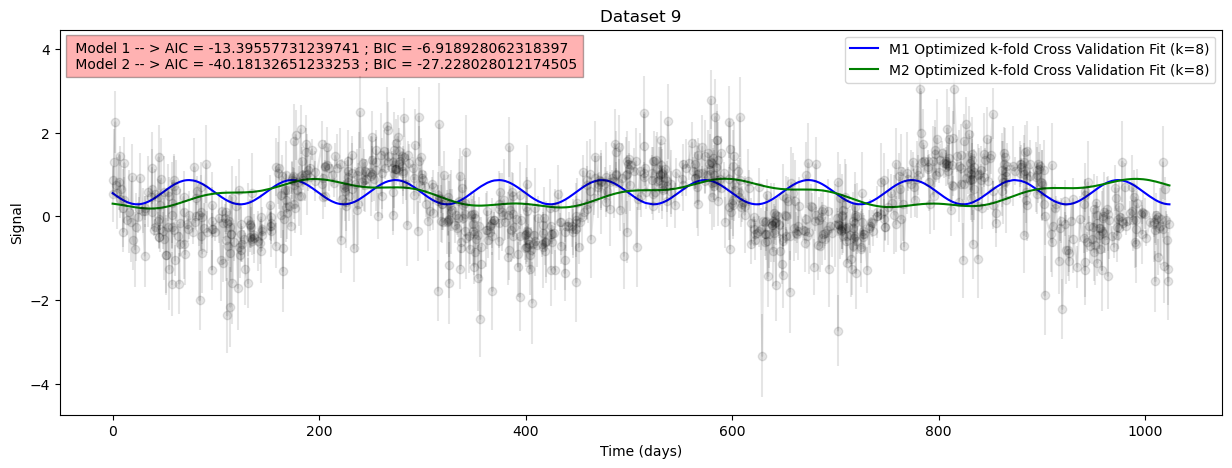

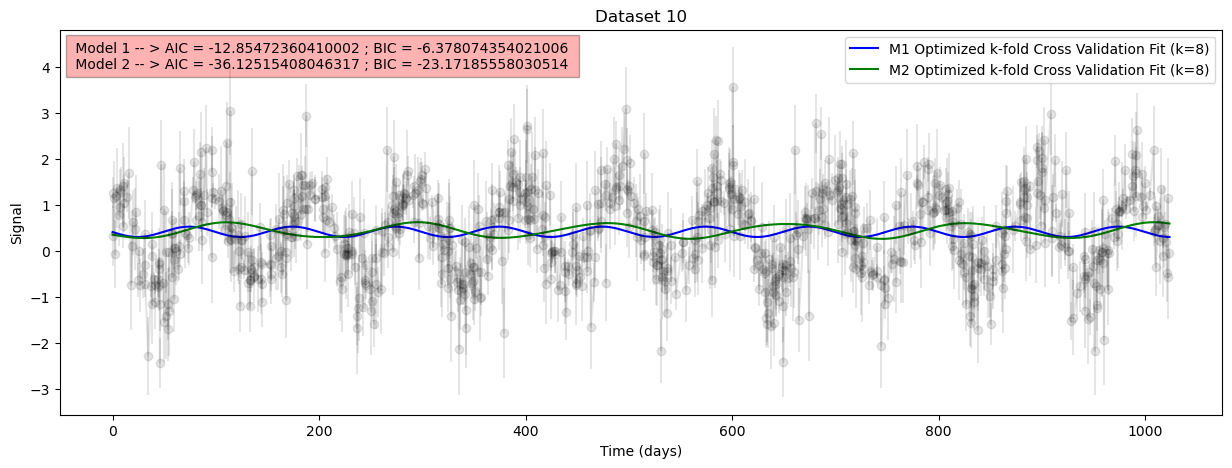

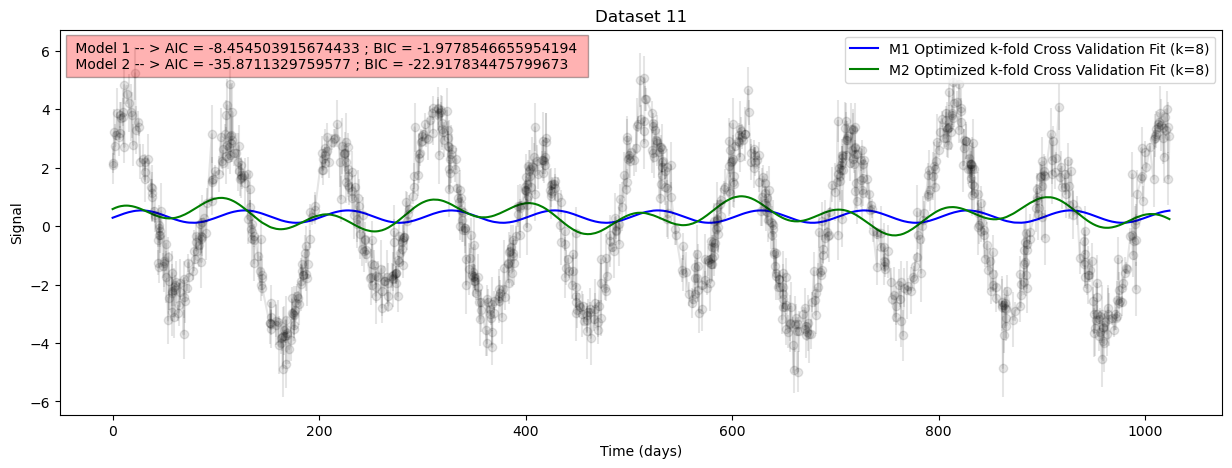

In [254]:
### MODEL 1
# Create the definition for our log-likelihood function and what it returns
def loglike_M1(pars, data, info):
    A1,A2,B = pars
    t, y = data
    sig = info
    T = 100

    # Create function for mu, using one signal with period of T = 100days    
    mu = A1 * np.cos(2* np.pi/T * t) + A2 * np.sin(2* np.pi/T * t) + B 

    return -0.5 * np.sum( ((y - mu)/sig )**2 )


### MODEL 2
# Create the definition for our log-likelihood function and what it returns
def loglike_M2(pars, data, info):
    Tp,A1,A2,A3,A4,B = pars
    t, y = data
    sig = info
    T = 100
    
    # Create function for mu, using 1st signal with period of T = 100days and 2nd signal with unknown period T'
    mu = A3 * np.cos(2* np.pi/Tp * t) + A4 * np.sin(2* np.pi/Tp * t) + \
         A1 * np.cos(2* np.pi/T * t)  + A2 * np.sin(2* np.pi/T * t)  + B 
    return -0.5 * np.sum( ((y - mu)/sig )**2 )

### Define AIC and BIC
# https://www.sciencedirect.com/topics/pharmacology-toxicology-and-pharmaceutical-science/akaike-information-criterion#:~:text=The%20Akaike%20information%20criterion%20(AIC)%20and%20the%20Bayesian%20information%20criterion,to%20its%20number%20of%20parameters.
def AIC(L, k):
    return -2 * np.log(L) + 2*k
    
def BIC(L, k, N):
    return -2 * np.log(L) + 2*k * np.log(N)

### Start Loop
for i in range(2,13):
    T = 100
    xdata = data[0]
    ydata_err = data[1]
    ydata = data[i]
    
    # Final K-fold cross validation parameters for Model 1 and Model 2
    M1_A1, M1_A2, M1_B  = [], [], []
    M2_A1, M2_A2, M2_A3, M2_A4, M2_B, M2_Tp = [], [], [], [], [], []

    
    # Split datapoints for each dataset into m subsets
    m = 8
    arr_x     = np.array_split(xdata, m)
    arr_y     = np.array_split(ydata, m)
    arr_yerr  = np.array_split(ydata_err, m)
    
    
    # Remove mth subset and concatenate the rest for parameter optimization, for each dataset
    for j in range(1,m):
        xd    = np.concatenate( np.delete(arr_x, m-1, 0)    )
        yd    = np.concatenate( np.delete(arr_y, m-1, 0)    )
        yderr = np.concatenate( np.delete(arr_yerr, m-1, 0) )
        
        
        ## Model 1 Parameter Optimization 
        # Loop log-likelood function for all datapoints for each graph
        Maxloglike_M1_s = pd.Series(dtype=object)
        argmaxloglike_M1_s = pd.Series(dtype=object)
        
        fun    = lambda x: -loglike_M1(x, (xd, yderr), yd)
        res_M1 = minimize(fun, [1,1,1])
    
        Maxloglike_M1_s          = -res_M1.fun  
        argmaxloglike_M1_s       =  res_M1.x  
        A1_M1, A2_M1, B_M1       =  res_M1.x                      # maximum likelihood parameters.

        ## Model 2 Parameter Optimization
        # Loop log-likelood function for all datapoints for each graph
        profloglike_s      = pd.Series(dtype=object)
        Tp_max             = pd.Series(dtype=object)
        Maxloglike_M2_s    = pd.Series(dtype=object)
        argmaxloglike_M2_s = pd.Series(dtype=object)
        
        Tps = np.linspace(1,1460,50)
        profloglike_s = []
        for Tp in Tps:
            fun    = lambda a: -loglike_M2( np.concatenate(([Tp],a)), (xd, yderr), yd)  
            res_Tp = minimize(fun, [1,1,1,1,1] )
            profloglike_s.append(-res_Tp.fun)
        
        # Plot Optimized Period vs log likelihood
        Tp_max = Tps[np.argmax(profloglike_s)]
        #pyplt.figure(figsize=(15, 5))
        #pyplt.plot(Tps, profloglike_s.at[i])
        #pyplt.xlabel("T'")
        #pyplt.ylabel("prof_loglike(T')")
        #pyplt.title("Dataset {}".format(i-1))

        # Reoptimize rest of parameters (A_1, A_2, A_3, A_4, B) using respective optimized T' 
        fun    = lambda a: -loglike_M2( np.concatenate(([ Tp_max ],a)), (xd, yderr), yd ) 
        res_M2 = minimize(fun, [1,1,1,1,1])  
        #print("dataset {}, Tp_argmax_M2 = {}, res.status = {}, max(loglike) {}, argmax = {} ".format(i-1, Tp_max.at[i], res.status, -res.fun, res.x)) 
    
        Maxloglike_M2_s                  = -res_M2.fun  
        argmaxloglike_M2_s               =  res_M2.x  
        A1_M2, A2_M2, A3_M2, A4_M2, B_M2 =  res_M2.x        # maximum likelihood parameters.
        #print("dataset {},  A_argmax_M2_signal1 = {}, A_argmax_M2_signal2 = {}  ".format(i-1, A_ML_M2_signal1, A_ML_M2_signal2 ))
      
        M1_A1.append(A1_M1)
        M1_A2.append(A2_M1)
        M1_B.append(B_M1)
        
        M2_A1.append(A1_M2)
        M2_A2.append(A2_M2)
        M2_A3.append(A3_M2)
        M2_A4.append(A4_M2)
        M2_B.append(B_M2)
        M2_Tp.append(Tp_max)
    
    # Find the mean for each parameter optimized for every held out mths, for each dataset
    A1_M1, A2_M1, B_M1 = np.mean(M1_A1), np.mean(M1_A2), np.mean(M1_B)
    A1_M2, A2_M2, A3_M2, A4_M2, B_M2, Tp_M2 = np.mean(M2_A1), np.mean(M2_A2), np.mean(M2_A3), np.mean(M2_A4),\
                                              np.mean(M2_B), np.mean(M2_Tp)
    
    # Plot the trained optimized paramters for each of the full datasets
    M1 = A1_M1 * np.cos(2* np.pi/T * data[0]) + A2_M1 * np.sin(2* np.pi/T * data[0]) + B_M1
    
    M2 = A3_M2 * np.cos(2* np.pi/Tp_M2 * data[0]) + A4_M2 * np.sin(2* np.pi/Tp_M2 * data[0]) +\
             A1_M2 * np.cos(2* np.pi/T * data[0]) + A2_M2 * np.sin(2* np.pi/T * data[0]) + B_M2
    
    print("Model 1 : dataset {} --> A1 = {},  A2 = {}, B = {} ".format(i-1, A1_M1, A2_M1, B_M1))
    
    print("Model 2 : dataset {} --> A1 = {},  A2 = {}, A3 = {}, A4 = {}, B = {}, Tp_max = {} "\
                    .format(i-1, A1_M2, A2_M2, A3_M2, A4_M2, B_M2, Tp_M2) )
    
    # Find AIC and BIC
    AIC_M1 = AIC( -loglike_M1( (A1_M1, A2_M1, B_M1), (data[0], data[1]), data[i]), 3)
    AIC_M2 = AIC( -loglike_M2( (A1_M2, A2_M2, A3_M2, A4_M2, B_M2, Tp_M2), (data[0], data[1]), data[i]), 6)
    print("AIC : dataset {} --> Model 1 = {},  Model 2 = {} ".format(i-1, AIC_M1, AIC_M2))
    
    BIC_M1 = BIC( -loglike_M1( (A1_M1, A2_M1, B_M1), (data[0], data[1]), data[i]), 3, 8)
    BIC_M2 = BIC( -loglike_M2( (A1_M2, A2_M2, A3_M2, A4_M2, B_M2, Tp_M2), (data[0], data[1]), data[i]), 6, 8)
    print("BIC : dataset {} --> Model 1 = {},  Model 2 = {} ".format(i-1, BIC_M1, BIC_M2))
    
    
    # Plot function for optimized parameters (A_1, A_2, A_3, A_4, B) for each each respective T'
    pyplt.figure(figsize=(15, 5))
    pyplt.errorbar(data[0], data[i], yerr=data[1], marker="o", color="black", alpha=0.1)
    pyplt.plot(data[0], M1, color='blue' , alpha=1.0, label = 'M1 Optimized k-fold Cross Validation Fit (k=8)')
    pyplt.plot(data[0], M2, color='green', alpha=1.0, label = 'M2 Optimized k-fold Cross Validation Fit (k=8)')
    pyplt.xlabel("Time (days)")
    pyplt.ylabel("Signal")
    pyplt.title("Dataset {}".format(i-1))
    plt.legend()
    ax = plt.gca()
    plt.text(0.01, 0.9, f' Model 1 -- > AIC = {AIC_M1} ; BIC = {BIC_M1} \n' +\
                        f' Model 2 -- > AIC = {AIC_M2} ; BIC = {BIC_M2}', 
                        transform=ax.transAxes, fontsize = 10, bbox = dict(facecolor = 'red', alpha = 0.3))

## Bonus Problem (not for credit): 
Do the same again, but compute the fully marginalized likelihood (Bayesian evidence) instead. How are you setting your priors, and how do your answers depend on those priors?